# [01: Price Regression with LightGBM](#toc0_)

This is a dummy example on how to build an algorithm which predicts article prices based on product characteristerics.
The purpose is to employ LightGBM to solve this regression problem and predict prices according the given data labels and to understand the feature contribution of each underlying variable.

**Keywords**: LightGBM, regression modelling, price prediction, Vinted

**Table of contents**<a id='toc0_'></a>    
- [01: Price Regression with LightGBM](#toc1_)    
  - [Introduction](#toc1_1_)    
    - [LightGBM - out of the box approach](#toc1_1_1_)    
    - [Loading packages and data](#toc1_1_2_)    
  - [Preprocessing](#toc1_2_)    
    - [Taking a deeper look into size title](#toc1_2_3_)    
    - [Taking a deeper look into brand title](#toc1_2_4_)    
    - [Approaches to size titles](#toc1_2_5_)    
    - [Approaches to brand titles](#toc1_2_6_)    
  - [LightGBM regression model](#toc1_3_)    
    - [Q-Q Plot](#toc1_3_1_)    
    - [Kolmogorov-Smirnov Test](#toc1_3_2_)    
  - [Analysis of the results](#toc1_4_)    
    - [SHapley Additive exPlanations](#toc1_4_1_)    
    - [Conclusions](#toc1_4_2_)    
  - [Future work](#toc1_5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Introduction](#toc0_)

### <a id='toc1_1_1_'></a>[LightGBM - out of the box approach](#toc0_)

LightGBM, short for Light Gradient Boosting Machine, is a powerful and efficient gradient boosting framework developed by Microsoft.
One of the key features of LightGBM is its ability to handle large datasets with millions of samples and features efficiently. It achieves this by using a novel tree-based learning algorithm that grows trees leaf-wise rather than level-wise, which reduces memory usage and speeds up training. 


LightGBM supports parallel and distributed computing, enabling it to leverage multicore CPUs and multiple physical infrastructures. The main advantage of LightGBM is its flexibility to run multiple objectives functions and cost functions as well as a wide array of hyperparam which can be tuned to optimize performance and adapt to problems.

### <a id='toc1_1_2_'></a>[Loading packages and data](#toc0_)

In [1]:
import pandas as pd
from sqlalchemy import create_engine
import plotly.express as px
import os
import json
import numpy as np
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import matplotlib.pyplot as plt
import statsmodels.api as sm
import shap
from scipy.stats import kstest
from sklearn.model_selection import train_test_split


In [4]:
def load_credentials(path = "aws_rds_credentials.json"):
     with open(path, 'r') as file:
          config = json.load(file)

     # set up credentials
     for key in config.keys():
          os.environ[key] = config[key]

     return


load_credentials()

aws_rds_url = f"postgresql://{os.environ['user']}:{os.environ['password']}@{os.environ['host']}:{os.environ['port']}/{os.environ['database']}?sslmode=require"

# Load a sample dataset
def load_data():
    engine = create_engine(aws_rds_url)
    sql_query = f"""SELECT size_title, color1, brand_title, price_numeric, status, catalog_id, package_size_id, country, product_id
                    FROM public.tracking_staging 
                    LIMIT 500000
                    """
    df = pd.read_sql(sql_query, engine)
    return (df)

data = load_data()
data.head(5)

,size_title,color1,brand_title,price_numeric,status,catalog_id,package_size_id,country,product_id
0,L,Cinzento,Vintage Dressing,20.0,Muito bom,1813.0,1.0,France,4251158223
1,L,Mostarda,Vintage Dressing,24.0,Muito bom,1858.0,2.0,France,4246240605
2,L / 40 / 12,Preto,Vintage Dressing,30.0,Muito bom,1078.0,2.0,France,4246219965
3,M,Preto,Vintage Dressing,20.0,Muito bom,264.0,1.0,France,4243019199
4,M,Branco,Vintage Dressing,35.0,Muito bom,1815.0,1.0,France,4243016636


## <a id='toc1_2_'></a>[Preprocessing](#toc0_)

Because the source table is a staging table, there are a lot of repeated records (only with different dates). We will keep only the last row per product_id.

In [5]:
data.drop_duplicates(subset='product_id', inplace=True, keep= "last")
data.head(5)

,size_title,color1,brand_title,price_numeric,status,catalog_id,package_size_id,country,product_id
1,L,Mostarda,Vintage Dressing,24.0,Muito bom,1858.0,2.0,France,4246240605
2,L / 40 / 12,Preto,Vintage Dressing,30.0,Muito bom,1078.0,2.0,France,4246219965
3,M,Preto,Vintage Dressing,20.0,Muito bom,264.0,1.0,France,4243019199
4,M,Branco,Vintage Dressing,35.0,Muito bom,1815.0,1.0,France,4243016636
9,M,Azul-marinho,Vintage Dressing,40.0,Muito bom,2534.0,2.0,France,4235231245


There is a huge loss of data when considering unique product_ids. Since the purpose of the pipeline is to track products accross time as well, the same product might have a registry for each day.

In [6]:
data.isnull().sum()

size_title            21
color1             10753
brand_title           21
price_numeric         21
status              2769
catalog_id            21
package_size_id     2769
country             2769
product_id             0
dtype: int64

**Issues so far**

- catalog_id is int64, other predictors are object. Need to convert them to categorical before feeding to LightGBM
- color1_id has missing values (why?)
    - after inspecting and being knowledgeable about the data, there are articles which by nature do not have colors (such as books)
- the most popular size_title is ""
    - after inspecting I realize this has to do with "sizeless" items such as books as well
- the most popular brand_title is ""
    - this means the article doesn't have a brand. this can have several reasons, not only due to the misc items but also I believe Vinted allowed the user to publish items with empty brands at some point (I haven't confirmed this)
- size_title has 230 unique values which is a lot, let's take a look into that later
    - why is that?
- brand_title has 4.7k unique values which is also a lot
    - why is that?

**Approaches**

- change dtypes
- create a dummy color1_id and assign it to articles missing color1_id (filling with value 0)
- replacing "" size_title with "no_size" for better semantic representation (otherwise users are left to guess what it means)
- replacing ""brand_title with "no_brand" for the same reason

In [7]:
data["size_title"] = data["size_title"].replace("", "no_size")
data["brand_title"] = data["brand_title"].replace("", "no_brand")
data["color1"] = data["color1"].fillna("no_color")
data.isnull().sum()

size_title           21
color1                0
brand_title          21
price_numeric        21
status             2769
catalog_id           21
package_size_id    2769
country            2769
product_id            0
dtype: int64

In [8]:
data = data.dropna()

### <a id='toc1_2_3_'></a>[Taking a deeper look into size title](#toc0_)

Size title has unbalanced labels.
- Sizes can be further divided into product types. For instance, we have:
    - M, XL, S, etc which are the standard clothing sizes
    - no_size for the products which do not have size labels
    - numeric sizes (40, 41) which refers to footwear
    - kids sizes (8 anos, 12 anos, etc)
    - cup sizes (95D, 80B)
    - jewelry (which im assuming 30 mm diameter refers to)
    - volume units (40 x 45 cm)
    - weight units (9-18kgs)
    - jeans sizes (waist measurements W33)

In [9]:
fig = px.bar(data['size_title'].value_counts(), 
             x=data['size_title'].value_counts().index, 
             y=data['size_title'].value_counts().values,
             labels={'x': 'Size Title', 'y': 'Count'},
             title='Count of Size Title')
fig

### <a id='toc1_2_4_'></a>[Taking a deeper look into brand title](#toc0_)

Brand titles has too many brands.
- A lot of the brands aren't even brands (such as dri-fit, b(?), GYM, MI(?), etc)
- There are brands that mean the same thing (such as local, locale or any other meaning of thrift clothing)

In [10]:
fig = px.bar(data['brand_title'].value_counts(), 
             x=data['brand_title'].value_counts().index, 
             y=data['brand_title'].value_counts().values,
             labels={'x': 'Brand Title', 'y': 'Count'},
             title='Count of Brand Title')
fig

### <a id='toc1_2_5_'></a>[Approaches to size titles](#toc0_)

- Feature engineering
    - We can easily split garments from shoes, if we consider shoes have only numeric values assigned to sizes
- Remove size classes below a certain threshold

In [11]:
label_counts = data['size_title'].value_counts()

# Filter the labels with more than 100 occurrences
labels_more_than_100 = label_counts[label_counts > 100].index.tolist()

# Filter the DataFrame based on the selected labels
data = data[data['size_title'].isin(labels_more_than_100)]
data['size_title'].unique()

array(['L', 'L / 40 / 12', 'M', 'no_size', '8 anos / 128 cm',
       '5 anos / 110 cm', '3 anos / 98 cm', '9-12 meses / 74\xa0cm',
       '18-24 meses / 86\xa0cm', 'S / 36 / 8', 'S', '10 anos / 140 cm',
       '6 anos / 116 cm', 'XXXL / 46 / 18', 'XL / 42 / 14',
       'XXL / 44 / 16', 'XS / 34 / 6', 'Tamanho único',
       '12 anos / 152 cm', '44', '4 anos / 104 cm', '41', 'M / 38 / 10',
       '37', '45', '40', 'XL', '42', '38', '43', '39', 'XXL', '36',
       'XXS / 32 / 4', '24-36 meses / 92 cm', 'XS', '16 anos / 176 cm',
       '12-18 meses / 80\xa0cm', 'PT 42 | W32', '42,5',
       '6-9 meses / 68 cm', '4XL / 48 / 20', '14 anos / 164 cm',
       'PT 40 | W30', '1-3 meses / 56\xa0cm', '3-6 meses / 62\xa0cm',
       '7 anos / 122 cm', 'Outro', '13 anos / 158 cm', '5XL / 50 / 22',
       'Até 1 mês / 50\xa0cm', '11 anos / 146 cm', 'PT 44 | W34',
       '9 anos / 134 cm'], dtype=object)

In [12]:
fig = px.bar(data['brand_title'].value_counts(), 
             x=data['brand_title'].value_counts().index, 
             y=data['brand_title'].value_counts().values,
             labels={'x': 'Brand Title', 'y': 'Count'},
             title='Count of Brand Title')
fig

### <a id='toc1_2_6_'></a>[Approaches to brand titles](#toc0_)

- Remove size classes below a certain threshold

In [13]:
label_counts = data['brand_title'].value_counts()

# Filter the labels with more than 100 occurrences
labels_more_than_100 = label_counts[label_counts > 100].index.tolist()

# Filter the DataFrame based on the selected labels
data = data[data['brand_title'].isin(labels_more_than_100)]
data['brand_title'].unique()

array(['Vintage Dressing', 'no_brand', 'Mango', 'Kiabi', 'Disney', 'Puma',
       'Zara', 'H&M', 'Primark', 'adidas', 'Ralph Lauren', 'Nike',
       'Bershka', 'Gémo', "Levi's", 'In Extenso', "Tape à l'œil",
       'Lacoste', 'Scarpe', 'Tommy Hilfiger', 'Jack & Jones', 'Local',
       'Shein', 'Jordan', 'Camaïeu', 'Pull & Bear', 'Stradivarius',
       'GUESS', 'Donna', 'Terranova', 'ONLY', 'TEX', 'Cache Cache',
       'Vans', 'Converse', 'Calvin Klein', 'sans marque',
       'The North Face', 'Timberland', 'Lefties', 'Hollister',
       'United Colors of Benetton', 'Pimkie', 'Okaïdi', 'Orchestra',
       'Vintage', 'Champion', 'Carhartt', 'Decathlon', 'Promod',
       'Inconnu', 'Jennyfer', 'C&A', 'Undiz', 'Etam', 'Naf Naf'],
      dtype=object)

In [14]:
label_counts = data['catalog_id'].value_counts()

# Filter the labels with more than 100 occurrences
labels_more_than_100 = label_counts[label_counts > 100].index.tolist()

# Filter the DataFrame based on the selected labels
data = data[data['catalog_id'].isin(labels_more_than_100)]
data["catalog_id"].unique()

array([2344.,   18.,  584., 1042., 1041., 1099.,  221., 1043., 1809.,
       1242., 2342., 2349., 2355., 1801., 1807., 1662., 1846., 1821.,
        582.,  224.,  222.,  534.,  538., 1842.,  198., 2360., 1204.,
       2336., 2632.,  190., 2343., 2351.,  158., 1059., 1065., 1844.,
        194.,  196., 1066., 1056.,  178.,  164.,  163.,  223.,  532.,
       1803., 1812., 2362., 2346., 1058., 1813.,  267., 1806., 1805.,
       1071., 1554.,  225., 2333., 2364., 2337.,  191.,  197., 1811.,
       2339., 2338., 2363.,  165., 1535., 1055., 2328.,  529.,  156.,
       2618.,  228., 1845., 2350.,  199.,  189.,  185.,  543.])

In [15]:
# LightGBM also can handle categorical data directly We go to probe its inner method

# Transform categorical features into the appropriate type that is expected by LightGBM
for c in data.columns:
    col_type = data[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        data[c] = data[c].astype('category')
data["catalog_id"] = data["catalog_id"].astype("category")
data["package_size_id"] = data["package_size_id"].astype("category")

,price_numeric,product_id
count,16549.000000,1.654900e+04
mean,12.395311,3.901338e+09
std,25.257353,6.770782e+08
min,1.000000,4.609642e+07
25%,3.000000,3.952101e+09
50%,5.000000,4.091346e+09
75%,12.000000,4.244311e+09
max,499.000000,4.431202e+09


In [16]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=["price_numeric"]), 
                                                    data["price_numeric"], 
                                                    test_size=0.2, 
                                                    random_state=42)

X_train.head(5)

,size_title,color1,brand_title,status,catalog_id,package_size_id,country,product_id
439137,XS / 34 / 6,Amarelo,Zara,Muito bom,1065.0,2.0,Espagne,620200552
265579,XS,Cinzento,Calvin Klein,Muito bom,267.0,1.0,Italia,4401641993
244663,S,Lilás,Pull & Bear,Muito bom,267.0,2.0,Portugal,4273300775
494555,XL / 42 / 14,Fúcsia,Decathlon,Muito bom,534.0,1.0,France,4102349148
456167,XL / 42 / 14,Castanho,no_brand,Novo sem etiquetas,191.0,1.0,Francia,3521835285


## <a id='toc1_3_'></a>[LightGBM regression model](#toc0_)

In [17]:
d_train=lgb.Dataset(X_train, 
                    label=y_train,
                    params={"max_bin":128})

# Define parameters for LightGBM
params = {
    'objective': 'regression',
    'metric': 'rmse',  # Root Mean Squared Error    
    'n_estimators': 500,
    'max_depth': 18,
    'num_leaves': 2**6,
    'learning_rate': 0.01
}

clf=lgb.train(params,
              d_train) 

# Prediction on the valid set
y_pred=clf.predict(X_test)

# postprocess function
y_pred = y_pred.astype(np.int16)
errors = y_pred - y_test

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `n_estimators` in params. Will use it instead of argument



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000846 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 389
[LightGBM] [Info] Number of data points in the train set: 13239, number of used features: 8
[LightGBM] [Info] Start training from score 12.401088
Mean Squared Error: 239.6667673716012


In [18]:
results = pd.DataFrame([y_pred, y_test]).T
results.columns = ["Prediction", "Test"]
results.head(5)

,Prediction,Test
0,6.0,5.0
1,5.0,2.0
2,4.0,13.0
3,10.0,20.0
4,9.0,7.0
...,...,...
3305,3.0,3.0
3306,3.0,1.0
3307,4.0,1.0
3308,8.0,15.0


Text(0.5, 1.0, 'Actual vs. Predicted')

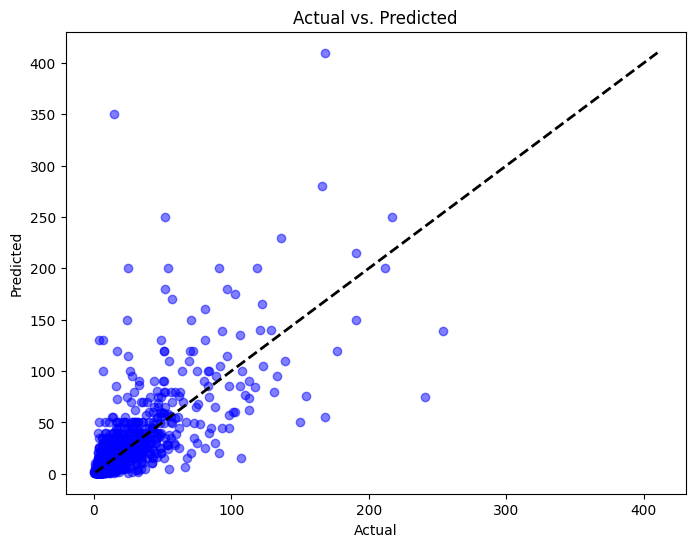

In [19]:
# y_pred/y_test plot
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, y_test, color='blue', alpha=0.5)
plt.plot([y_test.min(), 
          y_test.max()], 
          [y_test.min(), 
           y_test.max()], 
           'k--', 
           lw=2)  # Diagonal line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')

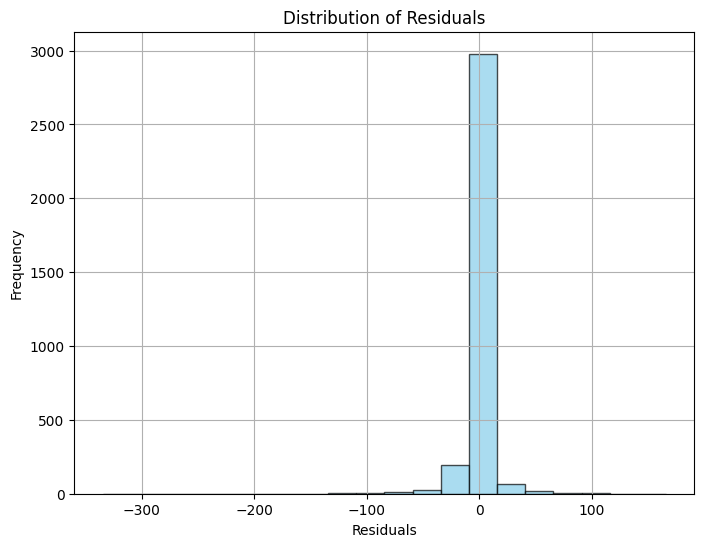

In [20]:
plt.figure(figsize=(8, 6))
plt.hist(errors, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True)

### <a id='toc1_3_1_'></a>[Q-Q Plot](#toc0_)

A visual representation of residue normality. Shows residues aren't a function of gaussian distribution which is obviosly not great.

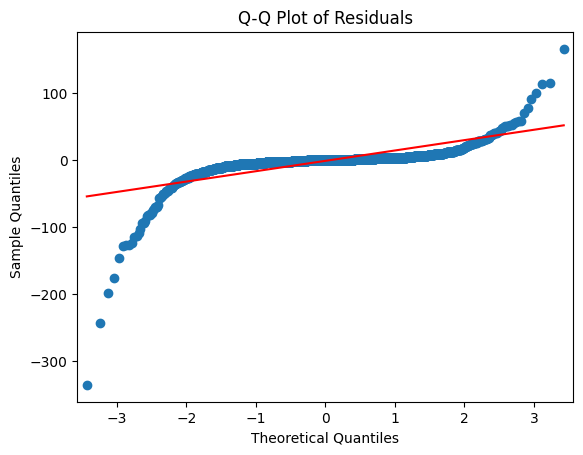

In [21]:
# Q-Q plot of residuals
sm.qqplot(errors, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

### <a id='toc1_3_2_'></a>[Kolmogorov-Smirnov Test](#toc0_)

KS test to test residues for normality.

In [22]:
ks_test_stat, ks_p_value = kstest(errors, 'norm')
print("\nKolmogorov-Smirnov Test:")
print("Test Statistic:", ks_test_stat)
print("p-value:", ks_p_value)


Kolmogorov-Smirnov Test:
Test Statistic: 0.3147121037013676
p-value: 7.085304163387243e-292


The Kolmogorov-Smirnov test is a statistical test used to assess whether a sample comes from a specific distribution (in this case, a normal distribution).

We reject the null hypothesis that the errors are normaly distributed.

In [2]:
# Calculate error scores for different values in brand_title and catalog_id
error_scores = {}
for label in ['brand_title', 'catalog_id']:
    unique_values = X_test[label].unique()
    for value in unique_values:
        mask = X_test[label] == value
        error_scores[(label, value)] = mean_squared_error(y_test[mask], y_pred[mask])

# Print error scores
for (label, value), error_score in error_scores.items():
    print(f"Mean Squared Error for {label} '{value}': {error_score}")

NameError: name 'X_test' is not defined

## <a id='toc1_4_'></a>[Analysis of the results](#toc0_)

### <a id='toc1_4_1_'></a>[SHapley Additive exPlanations](#toc0_)

SHAP or SHapley Additive exPlanations is a model agnostic framework which provides interpretability into individual models and feature importance. In short, SHAP accounts for the marginal contribution of each feature to the prediction scores.

We use TreeExplainer because it is used for explaining predictions from tree based models such as LightGBM.

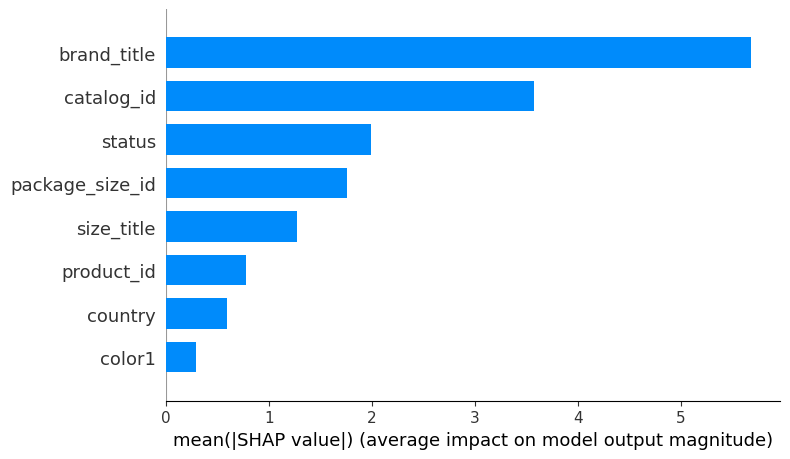

In [23]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)
pd.DataFrame(shap_values, columns= X_test.columns).apply(np.abs).mean(axis = 0)
shap.summary_plot(shap_values, 
                  X_test, 
                  feature_names=X_test.columns,
                  plot_type = "bar")

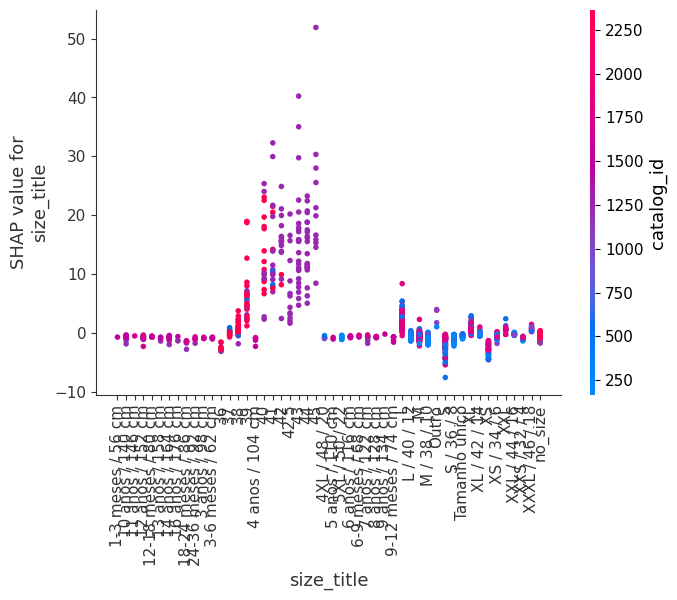

In [24]:
shap.dependence_plot("size_title", shap_values, X_test, interaction_index="catalog_id")

### <a id='toc1_4_2_'></a>[Conclusions](#toc0_)

- We developed a model with around 200-300 RMSE
- Our model doesn't yield robust results, as they vary a lot between runs
- As expected, one of the best predictors to price is brand title followed by the product catalog.
- The SHAP values per size_title with biggest value are linked to shoe sizes
- The SHAP values per size_title with biggest negative value are linked to women sizes
- In order to optimize revenue brand_title and catalogs are by far the best predictors of future revenue

Note: It's really tough to say which size title predicts higher price because there are a lot of confounding variables (namely product catalogs).

## <a id='toc1_5_'></a>[Future work](#toc0_)

- Preprocess the country labels into unique labels (France = Francia)
- Add cross validation to get more robust results
- Add hyperparam tuning
- Add stratified sampling and minimum size per labels in the SQL queries
- Do a small preprocessing step per each catalog